# Chapter 8 
 Modern Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (September 15, 2022) <br>
ISBN-13: 978-3031075650

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

In [1]:
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

# Modern analytic methods: Part II

In [2]:
import networkx as nx

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mistat

## Functional Data Analysis

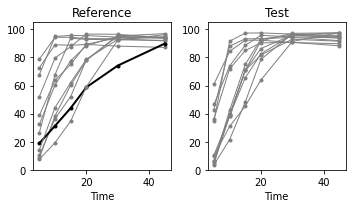

In [3]:
dissolution = mistat.load_data('DISSOLUTION.csv')

fig, axes = plt.subplots(ncols=2, figsize=(5, 3))
for label, group in dissolution.groupby('Label'):
  ax = axes[0] if label.endswith('R') else axes[1]
  color = 'black' if label == 'T5R' else 'grey'
  lw = 2 if label == 'T5R' else 1
  group.plot(x='Time', y='Data', color=color, ax=ax,
             marker='o', markersize=3, lw=lw)
for ax in axes:
  ax.get_legend().remove()
  ax.set_ylim(0, 105)
axes[0].set_title('Reference')
axes[1].set_title('Test')
plt.tight_layout()
plt.show()

In [4]:
from skfda import FDataGrid
from skfda.representation.interpolation import SplineInterpolation


# convert the data to FDataGrid
data = []
labels = []
names = []
for label, group in dissolution.groupby('Label'):
  data.append(group['Data'].values)
  labels.append('Reference' if label.endswith('R') else 'Test')
  names.append(label)
labels = np.array(labels)
grid_points = np.array(sorted(dissolution['Time'].unique()))
fd = FDataGrid(np.array(data), grid_points,
       dataset_name='Dissolution',
       argument_names=['Time'],
       coordinate_names=['Dissolution'],
       interpolation=SplineInterpolation(2))

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [5]:
from skfda.exploratory import stats

mean_ref = stats.mean(fd[labels=='Reference'])
mean_test = stats.mean(fd[labels=='Test'])
means = mean_ref.concatenate(mean_test)

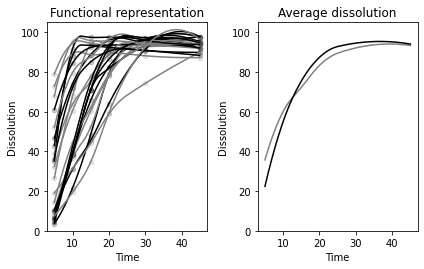

In [6]:
group_colors = {'Reference': 'grey', 'Test': 'black'}

fig, axes = plt.subplots(ncols=2)

fd.plot(axes=[axes[0]], group=labels, group_colors=group_colors)
for label, group in dissolution.groupby('Label'):
  color = 'grey' if label.endswith('R') else 'black'
  group.plot.scatter(x='Time', y='Data', c=color, ax=axes[0], alpha=0.2)

means.plot(axes=[axes[1]], group=['Reference', 'Test'],
           group_colors=group_colors)

fig.suptitle('')
axes[0].set_title('Functional representation')
axes[1].set_title('Average dissolution')
for ax in axes:
  ax.set_ylim(0, 105)
  ax.set_ylabel('Dissolution')
plt.tight_layout()
plt.show()

In [7]:
from skfda.preprocessing.registration import ShiftRegistration
shift_registration = ShiftRegistration()
fd_registered = shift_registration.fit_transform(fd)

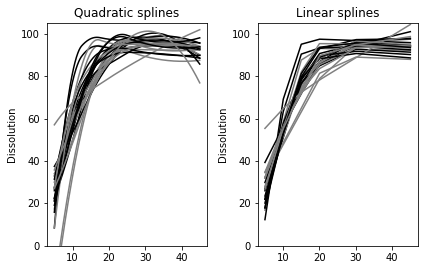

In [8]:
fig, axes = plt.subplots(ncols=2)
fd_registered.plot(axes=[axes[0]], group=labels, group_colors=group_colors)

# switch to linear spline interpolation
fd = FDataGrid(np.array(data), grid_points,
       dataset_name='Dissolution',
       argument_names=['Time'],
       coordinate_names=['Dissolution'],
       interpolation=SplineInterpolation(1, monotone=True))
fd_registered = shift_registration.fit_transform(fd)
fd_registered.plot(axes=[axes[1]], group=labels, group_colors=group_colors)

fig.suptitle('')
axes[0].set_title('Quadratic splines')
axes[1].set_title('Linear splines')
for ax in axes:
  ax.set_ylim(0, 105)
  ax.set_ylabel('Dissolution')
plt.tight_layout()
plt.show()

In [9]:
from skfda.exploratory.outliers import BoxplotOutlierDetector as IQROutlierDetector

out_detector = IQROutlierDetector()
outliers = out_detector.fit_predict(fd)
print('Outlier:')
for name, outlier in zip(names, outliers):
  if outlier == 1:
    continue
  print('  ', name)

Outlier:
   T5R


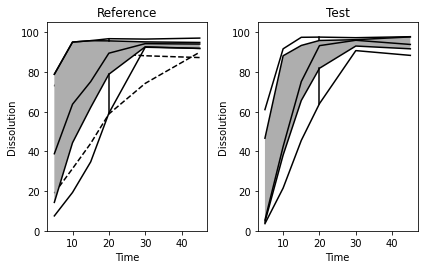

In [10]:
from skfda.exploratory.visualization import Boxplot
from matplotlib.colors import LinearSegmentedColormap

def addBoxplot(fd, ax):
  cm = LinearSegmentedColormap.from_list('fda', ['grey', 'lightgrey'])
  boxplot = Boxplot(fd, axes=[ax])
  boxplot.barcol = 'black'
  boxplot.outliercol = 'black'
  boxplot.colormap = cm
  boxplot.plot()

fig, axes = plt.subplots(ncols=2)
addBoxplot(fd[labels=='Reference'], axes[0])
addBoxplot(fd[labels=='Test'], axes[1])
fig.suptitle('')
axes[0].set_title('Reference')
axes[1].set_title('Test')
for ax in axes:
  ax.set_ylim(0, 105)
  ax.set_ylabel('Dissolution')
plt.tight_layout()
plt.show()

In [11]:
from skfda.inference.anova import oneway_anova
stat, p_val = oneway_anova(fd[labels=='Reference'], fd[labels=='Test'], random_state=1)
print("Statistic: {:.3f}".format(stat))
print("p-value: {:.3f}".format(p_val))

qstat, p_val = oneway_anova(fd_registered[labels=='Reference'], fd_registered[labels=='Test'], random_state=1)
print("Statistic: {:.3f}".format(stat))
print("p-value: {:.3f}".format(p_val))

Statistic: 9117.337
p-value: 0.000
Statistic: 9117.337
p-value: 0.000


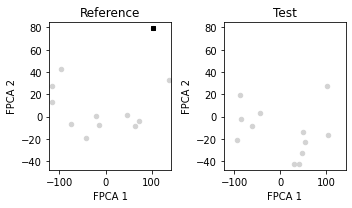

In [12]:
from skfda.preprocessing.dim_reduction.projection import FPCA
fpca = FPCA(n_components=2)
fpca.fit(fd)

df = pd.DataFrame(fpca.transform(fd), columns=['FPCA 1', 'FPCA 2'])
df['labels'] = labels
df['names'] = names

lim1 = (min(df['FPCA 1'])-5, max(df['FPCA 1'])+5)
lim2 = (min(df['FPCA 2'])-5, max(df['FPCA 2'])+5)
fig, axes = plt.subplots(ncols=2, figsize=(5, 3))
for ax, label in zip(axes, ['Reference', 'Test']):
  subset = df[df.labels == label]
  subset.plot.scatter(x='FPCA 1', y='FPCA 2', ax=ax, color='lightgrey')
  ax.set_title(label)
  ax.set_xlim(*lim1)
  ax.set_ylim(*lim2)
outlier = df[df.names == 'T5R']
outlier.plot.scatter(x='FPCA 1', y='FPCA 2', color='black',
  marker='s', ax=axes[0])

plt.tight_layout()
plt.show()

## Text Analytics

In [13]:
incidents = mistat.load_data('AIRCRAFTINCIDENTS.csv')
print(incidents.shape)

(1906, 27)


In [14]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def preprocessor(text):
    text = text.lower()
    text = re.sub(r'\d[\d,]*', '', text)
    text = '\n'.join(line for line in text.split('\n')
                     if not line.startswith('ntsb'))
    return text

vectorizer = CountVectorizer(preprocessor=preprocessor,
                             stop_words='english')
counts = vectorizer.fit_transform(incidents['Final Narrative'])
print('shape of DTM', counts.shape)
print('total number of terms', np.sum(counts))

shape of DTM (1906, 8430)
total number of terms 163883


In [15]:
termCounts = np.array(counts.sum(axis=0)).flatten()
topCounts = termCounts.argsort()
terms = vectorizer.get_feature_names_out()
for n in reversed(topCounts[-10:]):
  print(f'{terms[n]} & {termCounts[n]} \\\\')

pilot & 5227 \\
airplane & 5037 \\
engine & 2359 \\
flight & 2194 \\
landing & 2161 \\
runway & 2112 \\
left & 1754 \\
feet & 1609 \\
fuel & 1589 \\
right & 1555 \\


In [16]:
tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [17]:
narrative = incidents['Final Narrative'][0]
narrative = '\n'.join(narrative.split('\n')[2:])

In [18]:
terms = vectorizer.get_feature_names_out()
docterms = counts[0,:].nonzero()[1]
df = pd.DataFrame({
  'Terms': [terms[i] for i in docterms],
  'Counts': [counts[0, i] for i in docterms],
  'TF-IDF': [tfidf[0, i] for i in docterms],
  'weight': [tfidf[0, i] / counts[0, i] for i in docterms]
})
df = df.sort_values('TF-IDF', ascending=False)

table = df.head(10).style
table = table.format(precision=3)
table = table.hide(axis='index')
print(table.to_latex(hrules=True))

\begin{tabular}{lrrr}
\toprule
Terms & Counts & TF-IDF & weight \\
\midrule
lincoln & 2 & 14.908 & 7.454 \\
logan & 1 & 8.553 & 8.553 \\
said & 3 & 8.234 & 2.745 \\
illinois & 1 & 7.166 & 7.166 \\
upside & 1 & 6.356 & 6.356 \\
came & 2 & 5.671 & 2.836 \\
plowed & 1 & 5.557 & 5.557 \\
runway & 3 & 5.487 & 1.829 \\
county & 1 & 5.462 & 5.462 \\
feet & 3 & 5.408 & 1.803 \\
\bottomrule
\end{tabular}



In [19]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
svd = TruncatedSVD(10)
tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(tfidf)
print(lsa_tfidf.shape)

(1906, 10)


In [20]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)
print(df.iloc[:, :10].style.format(precision=2).hide(axis='index').to_latex(hrules=True))
print(df.iloc[:, 10:].style.format(precision=2).hide(axis='index').to_latex(hrules=True))

\begin{tabular}{lrlrlrlrlr}
\toprule
Topic 1 & Loading 1 & Topic 2 & Loading 2 & Topic 3 & Loading 3 & Topic 4 & Loading 4 & Topic 5 & Loading 5 \\
\midrule
airplane & 0.35 & fuel & 0.67 & helicopter & 0.61 & helicopter & 0.35 & fuel & 0.34 \\
pilot & 0.28 & engine & 0.29 & rotor & 0.24 & gear & 0.33 & knots & 0.22 \\
runway & 0.23 & tank & 0.24 & flight & 0.14 & landing & 0.27 & helicopter & 0.20 \\
landing & 0.19 & tanks & 0.12 & tail & 0.10 & right & 0.21 & wind & 0.17 \\
fuel & 0.19 & gallons & 0.12 & engine & 0.10 & main & 0.20 & tank & 0.17 \\
engine & 0.19 & power & 0.12 & feet & 0.10 & left & 0.17 & aircraft & 0.14 \\
left & 0.17 & selector & 0.09 & blades & 0.10 & rotor & 0.15 & runway & 0.13 \\
right & 0.15 & forced & 0.09 & collective & 0.10 & fuel & 0.12 & winds & 0.12 \\
reported & 0.15 & carburetor & 0.08 & ground & 0.09 & student & 0.12 & degrees & 0.11 \\
flight & 0.14 & loss & 0.06 & instructor & 0.08 & instructor & 0.11 & left & 0.11 \\
\bottomrule
\end{tabular}

\beg

## Bayesian Networks

In [21]:
from pgmpy.estimators import HillClimbSearch

abc = mistat.load_data('ABC2.csv')
abc = abc.drop(columns=['ID'])

est = HillClimbSearch(data=abc)
model = est.estimate(max_indegree=4, max_iter=int(1e4), show_progress=False,
                     scoring_method='k2score')

In [22]:
import pydotplus

def layoutGraph(dot_data, pdfFile):
    graph = pydotplus.graph_from_dot_data(dot_data)
    with open(pdfFile, 'wb') as f:
      f.write(graph.create_pdf())

def createGraph(G, pdfFile):
    sortedNodes = list(nx.topological_sort(G))
    commonSettings = """
    edge [ fontsize=11, color=gray55 ];
    # size="10,10"
    graph [ranksep="0.2", dpi=300];
    """
    def makeNode(label):
        return f'{label} [ label="{label}", fontsize=11, color=white ];'
    def makeEdge(edge):
        fromNode, toNode = edge
        return f'{fromNode} -> {toNode};'

    allNodes = '\n'.join(makeNode(node) for node in sortedNodes)
    allEdges = '\n'.join(makeEdge(edge) for edge in G.edges)

    s = f"""
    digraph ethane {{
    { commonSettings }
    { allNodes }
    { allEdges }
     }}
     """
    return layoutGraph(s, pdfFile)


In [23]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

# convert to BayesianNetwork and fit data
model = BayesianNetwork(model.edges())
model.fit(data=abc, estimator=MaximumLikelihoodEstimator)

In [24]:
for cpd in model.get_cpds():
  df = pd.DataFrame(cpd.values)
  v0 = cpd.variables[0]
  df.index = pd.MultiIndex.from_tuples([(v0, state) for state in cpd.state_names[v0]])
  if len(cpd.variables) > 1:
    v1 = cpd.variables[1]
    df.columns = pd.MultiIndex.from_tuples([(v1, state) for state in cpd.state_names[v1]])
  print(df.round(3))
  break

                 Equipment                            
                       1.0    2.0    3.0    4.0    5.0
Satisfaction 1.0       0.8  0.167  0.033  0.008  0.000
             2.0       0.0  0.444  0.100  0.042  0.154
             3.0       0.0  0.278  0.533  0.158  0.077
             4.0       0.2  0.111  0.283  0.583  0.385
             5.0       0.0  0.000  0.050  0.208  0.385


In [25]:
from pgmpy.inference import VariableElimination, BeliefPropagation
infer = BeliefPropagation(model)
results = {i: infer.query(variables=['Repurchase'],
                          evidence={'TechnicalSup': i}).values
           for i in range(1, 6)}

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

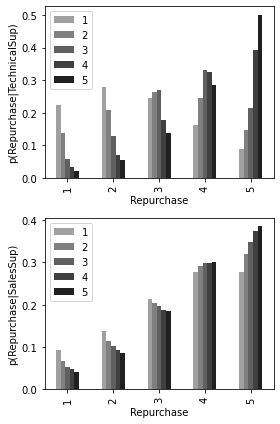

In [26]:
fig, axes = plt.subplots(nrows=2,figsize=(4, 6))

cmap = plt.get_cmap("gray")
greyColors = [cmap(i/8) for i in reversed(range(1, 6))]

ax = axes[0]
df = pd.DataFrame(results, index=range(1,6))
df.plot(kind='bar', stacked=False, ax=ax, color=greyColors)
ax.set_xlabel('Repurchase')
ax.set_ylabel('p(Repurchase|TechnicalSup)')

results = {i: infer.query(variables=['Repurchase'],
                          evidence={'SalesSup': i}).values
           for i in range(1, 6)}
ax = axes[1]
df = pd.DataFrame(results, index=range(1,6))
df.plot(kind='bar', stacked=False, ax=ax, color=greyColors)
ax.set_xlabel('Repurchase')
ax.set_ylabel('p(Repurchase|SalesSup)')

plt.tight_layout()
plt.show()

In [27]:
import itertools
cmap = plt.get_cmap("gray")
greyColors = [cmap(i/8) for i in reversed(range(1, 6))]

def inferAll(evidence=None):
    results = {}
    countries = list(abc.country.unique())
    for column in abc.columns:
        if evidence is not None and column in evidence:
            if column == 'country':
                country = evidence['country']
                result = [0] * len(countries)
                result[countries.index(country)] = 1
                idx = countries
            else:
                idx = range(1, 6)
                result = [0] * 5
                result[evidence[column] - 1] = 1
        else:
            result = infer.query(variables=[column], evidence=evidence, show_progress=False)
            idx = range(1, 6)
            if column == 'country':
                idx = countries
            result = result.values
        results[column] = pd.DataFrame({column: result}, index=idx)
    return results

def plotInferAll(results):
    fig, axes = plt.subplots(ncols=4, nrows=3)
    for column, ax in itertools.zip_longest(results, itertools.chain(*axes)):
        if column is None:
            ax.axis('off')
            continue
        results[column].plot(kind='bar', color='grey', ax=ax, legend=False)
        ax.set_title(column)
        ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()

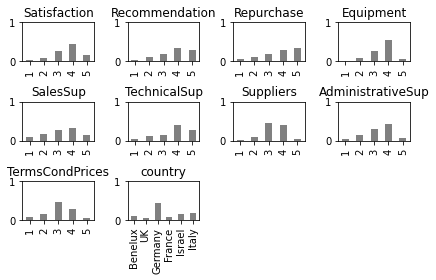

In [28]:
results = inferAll()
plotInferAll(results)

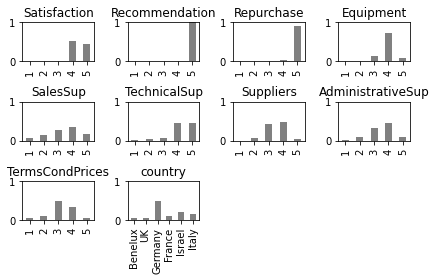

In [29]:
results = inferAll(evidence={'Recommendation': 5})
plotInferAll(results)

In [30]:
results = {i: infer.query(variables=['TechnicalSup'],
                          evidence={'country': i}).values
           for i in sorted(abc.country.unique())}
df = pd.DataFrame(results, range(1,6))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

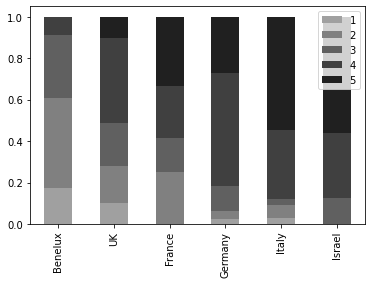

In [31]:
# sort columns by increasing estimated technical support score
columns = sorted(df.columns, key=lambda c: np.sum(np.arange(1, 6) * df[c]))
df = df[columns]
df.transpose().plot(kind='bar', stacked=True, color=greyColors)
plt.show()

## Causality Models

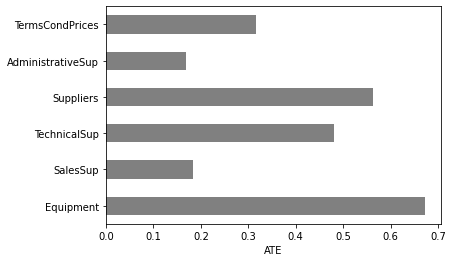

In [32]:
from pgmpy.inference.CausalInference import CausalInference
ci = CausalInference(model)
ignore = ('Satisfaction', 'country', 'Recommendation', 'Repurchase')
interventions = [c for c in abc.columns if c not in ignore]
ate = {c: ci.estimate_ate(c, 'Satisfaction', abc, missing='drop')
       for c in interventions}
ax = pd.Series(ate).plot.barh(color='grey')
ax.set_xlabel('ATE')
plt.show()

In [33]:
distTower = mistat.load_data('DISTILLATION-TOWER.csv')
distTower = distTower.set_index('Date')
subset = ['VapourPressure', 'Temp1', 'Temp2', 'Temp3', 'Temp4', 'Temp5',
          'Temp6', 'Temp7', 'Temp8', 'Temp9', 'Temp10','Temp11','Temp12']
distTower = distTower[subset]
results = []
for c in subset[1:]:
    # use pct_change to make time series stationary
    data = distTower[["VapourPressure", c]].pct_change().dropna()
    gc_res = grangercausalitytests(data, 10, verbose=False)
    results.append({f'lag {i}': gc[0]['ssr_ftest'][1]
                    for i, gc in gc_res.items()})
df = pd.DataFrame(results, index=subset[1:])
df['id'] = df.index

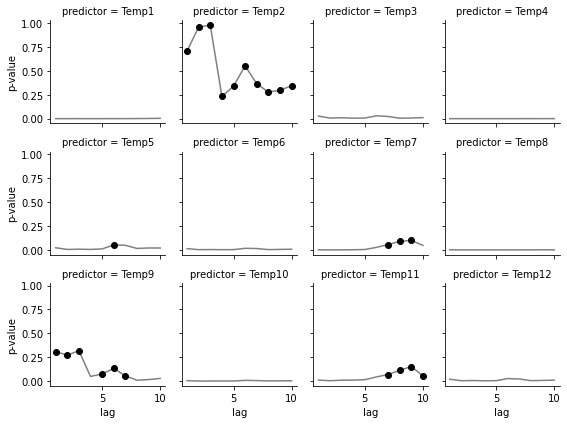

In [34]:
df = pd.wide_to_long(df, 'lag ', 'id', 'VapourPressure')
df = df.reset_index()
df.columns = ('predictor', 'lag', 'p-value')

def plotLag(x, y, **kwargs):
    ax = plt.gca()
    ax.plot(x, y, **kwargs)
    sig = y > 0.05
    ax.scatter(x[sig], y[sig], color='black',zorder=10)

g = sns.FacetGrid(df, col="predictor", col_wrap=4, height=2)
g.map(plotLag, 'lag', 'p-value', color='grey')
plt.show()

## Chapter Highlights

## Exercises